# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

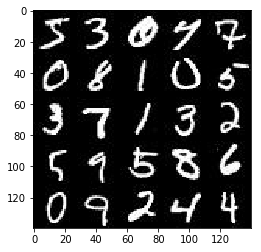

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

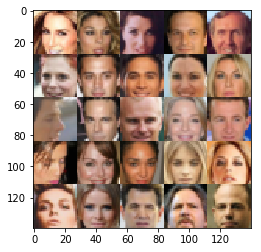

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\Users\poia0\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [73]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels))
    inputs_Z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
                                 

    return inputs_real, inputs_Z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\poia0\\Anaconda3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\poia0\\Anaconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\poia0\\Anaconda3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\poia0\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\poia0\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\poia0\\Anaconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.p

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [76]:
def discriminator(images, reuse=False, alpha = 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [77]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [78]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [79]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [80]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [83]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt, feed_dict={input_real: batch_images,
                                              input_z: batch_z,
                                              lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images,
                                             input_z: batch_z,
                                             lr: learning_rate})
                
                steps += 1
                if steps % 10 == 0:
                    train_loss_disc = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: batch_z})
                    print('Epoch %d/%d Discriminator loss %.4f Generator loss %.4f' % (epoch_i+1,
                                                                                       epoch_count,
                                                                                       train_loss_disc,
                                                                                       train_loss_gen ))
                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator loss 1.3153 Generator loss 0.4789
Epoch 1/2 Discriminator loss 0.9205 Generator loss 3.3413
Epoch 1/2 Discriminator loss 1.0513 Generator loss 2.5488
Epoch 1/2 Discriminator loss 0.9480 Generator loss 0.7221
Epoch 1/2 Discriminator loss 2.6926 Generator loss 0.1014
Epoch 1/2 Discriminator loss 1.2999 Generator loss 3.3361
Epoch 1/2 Discriminator loss 1.5364 Generator loss 0.3513
Epoch 1/2 Discriminator loss 1.1129 Generator loss 0.8696
Epoch 1/2 Discriminator loss 1.0844 Generator loss 0.7323
Epoch 1/2 Discriminator loss 1.2652 Generator loss 1.2278


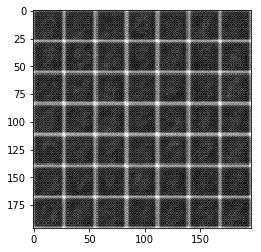

Epoch 1/2 Discriminator loss 1.8681 Generator loss 0.2176
Epoch 1/2 Discriminator loss 1.3914 Generator loss 0.8626
Epoch 1/2 Discriminator loss 1.6467 Generator loss 0.2968
Epoch 1/2 Discriminator loss 1.3931 Generator loss 0.9082
Epoch 1/2 Discriminator loss 1.5782 Generator loss 0.3284
Epoch 1/2 Discriminator loss 1.4047 Generator loss 1.2342
Epoch 1/2 Discriminator loss 1.4423 Generator loss 0.4175
Epoch 1/2 Discriminator loss 1.3835 Generator loss 1.2138
Epoch 1/2 Discriminator loss 1.5249 Generator loss 0.3425
Epoch 1/2 Discriminator loss 1.1926 Generator loss 1.0336


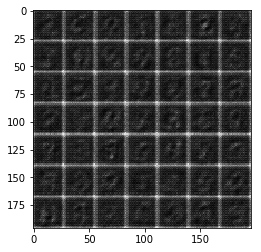

Epoch 1/2 Discriminator loss 1.4202 Generator loss 0.4133
Epoch 1/2 Discriminator loss 1.4397 Generator loss 1.1691
Epoch 1/2 Discriminator loss 1.2735 Generator loss 0.6111
Epoch 1/2 Discriminator loss 1.4156 Generator loss 1.1210
Epoch 1/2 Discriminator loss 1.2731 Generator loss 0.4776
Epoch 1/2 Discriminator loss 1.2383 Generator loss 1.0742
Epoch 1/2 Discriminator loss 1.1284 Generator loss 0.6010
Epoch 1/2 Discriminator loss 1.1303 Generator loss 0.7660
Epoch 1/2 Discriminator loss 1.4782 Generator loss 1.5384
Epoch 1/2 Discriminator loss 1.3521 Generator loss 0.4170


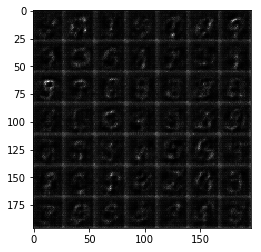

Epoch 1/2 Discriminator loss 1.1048 Generator loss 0.9752
Epoch 1/2 Discriminator loss 1.4570 Generator loss 0.3819
Epoch 1/2 Discriminator loss 1.0361 Generator loss 1.1768
Epoch 1/2 Discriminator loss 1.1944 Generator loss 0.5165
Epoch 1/2 Discriminator loss 1.0772 Generator loss 1.1361
Epoch 1/2 Discriminator loss 1.3705 Generator loss 0.4107
Epoch 1/2 Discriminator loss 1.0583 Generator loss 1.2928
Epoch 1/2 Discriminator loss 0.9907 Generator loss 0.7238
Epoch 1/2 Discriminator loss 1.1788 Generator loss 1.4640
Epoch 1/2 Discriminator loss 1.0817 Generator loss 0.6605


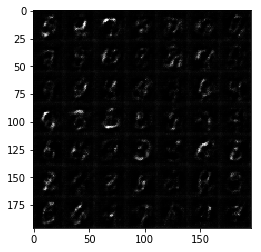

Epoch 1/2 Discriminator loss 1.0283 Generator loss 0.7929
Epoch 1/2 Discriminator loss 1.1144 Generator loss 1.6131
Epoch 1/2 Discriminator loss 1.2859 Generator loss 0.4740
Epoch 1/2 Discriminator loss 1.0185 Generator loss 1.4999
Epoch 1/2 Discriminator loss 0.9489 Generator loss 0.7169
Epoch 1/2 Discriminator loss 0.9395 Generator loss 0.7416
Epoch 1/2 Discriminator loss 1.0706 Generator loss 1.6394
Epoch 1/2 Discriminator loss 0.9330 Generator loss 0.7497
Epoch 1/2 Discriminator loss 0.9006 Generator loss 1.0071
Epoch 1/2 Discriminator loss 0.9223 Generator loss 1.4205


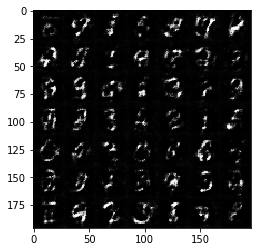

Epoch 1/2 Discriminator loss 1.3137 Generator loss 0.4203
Epoch 1/2 Discriminator loss 1.0313 Generator loss 1.4763
Epoch 1/2 Discriminator loss 1.0336 Generator loss 0.7023
Epoch 1/2 Discriminator loss 0.7763 Generator loss 1.3651
Epoch 1/2 Discriminator loss 1.0003 Generator loss 0.6644
Epoch 1/2 Discriminator loss 0.7759 Generator loss 1.2333
Epoch 1/2 Discriminator loss 0.8615 Generator loss 1.0145
Epoch 1/2 Discriminator loss 0.9167 Generator loss 1.8646
Epoch 1/2 Discriminator loss 1.2113 Generator loss 0.4639
Epoch 1/2 Discriminator loss 0.8491 Generator loss 1.1157


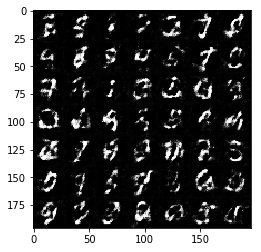

Epoch 1/2 Discriminator loss 0.8628 Generator loss 0.8122
Epoch 1/2 Discriminator loss 0.7140 Generator loss 1.0404
Epoch 1/2 Discriminator loss 1.2306 Generator loss 0.4312
Epoch 1/2 Discriminator loss 0.8543 Generator loss 1.8992
Epoch 1/2 Discriminator loss 0.8595 Generator loss 0.7795
Epoch 1/2 Discriminator loss 0.9637 Generator loss 1.6896
Epoch 1/2 Discriminator loss 1.1393 Generator loss 0.5527
Epoch 1/2 Discriminator loss 1.0557 Generator loss 1.4313
Epoch 1/2 Discriminator loss 0.9666 Generator loss 0.6789
Epoch 1/2 Discriminator loss 0.8104 Generator loss 1.6481


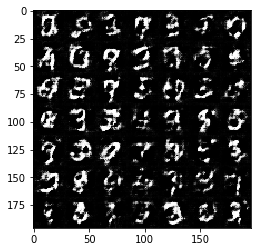

Epoch 1/2 Discriminator loss 0.9015 Generator loss 0.7464
Epoch 1/2 Discriminator loss 0.6659 Generator loss 1.5728
Epoch 1/2 Discriminator loss 1.1051 Generator loss 0.5264
Epoch 1/2 Discriminator loss 0.8561 Generator loss 1.9200
Epoch 1/2 Discriminator loss 1.0226 Generator loss 0.6416
Epoch 1/2 Discriminator loss 0.7915 Generator loss 0.8892
Epoch 1/2 Discriminator loss 0.8914 Generator loss 1.4445
Epoch 1/2 Discriminator loss 1.2091 Generator loss 0.4921
Epoch 1/2 Discriminator loss 0.8133 Generator loss 1.5878
Epoch 1/2 Discriminator loss 1.1500 Generator loss 0.5088


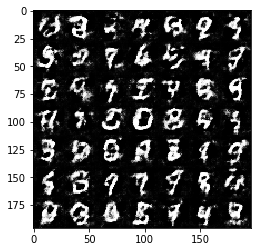

Epoch 1/2 Discriminator loss 0.8043 Generator loss 1.4907
Epoch 1/2 Discriminator loss 0.7838 Generator loss 1.2526
Epoch 1/2 Discriminator loss 1.1318 Generator loss 0.5333
Epoch 1/2 Discriminator loss 0.7779 Generator loss 1.1550
Epoch 1/2 Discriminator loss 0.7780 Generator loss 0.8702
Epoch 1/2 Discriminator loss 1.4141 Generator loss 2.5620
Epoch 1/2 Discriminator loss 1.6361 Generator loss 0.3112
Epoch 1/2 Discriminator loss 0.8823 Generator loss 1.0635
Epoch 1/2 Discriminator loss 1.2002 Generator loss 0.5098
Epoch 1/2 Discriminator loss 1.1547 Generator loss 1.8757


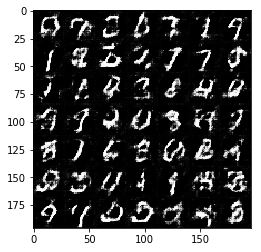

Epoch 1/2 Discriminator loss 1.1659 Generator loss 0.5266
Epoch 1/2 Discriminator loss 1.0079 Generator loss 1.5307
Epoch 1/2 Discriminator loss 1.0338 Generator loss 0.7312
Epoch 2/2 Discriminator loss 1.0186 Generator loss 1.1885
Epoch 2/2 Discriminator loss 1.2363 Generator loss 0.4643
Epoch 2/2 Discriminator loss 0.9348 Generator loss 1.1928
Epoch 2/2 Discriminator loss 1.2839 Generator loss 0.4850
Epoch 2/2 Discriminator loss 1.0292 Generator loss 1.2831
Epoch 2/2 Discriminator loss 1.3547 Generator loss 0.4167
Epoch 2/2 Discriminator loss 1.0677 Generator loss 0.9646


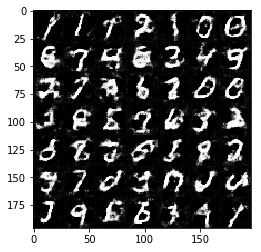

Epoch 2/2 Discriminator loss 1.1307 Generator loss 0.6204
Epoch 2/2 Discriminator loss 1.0449 Generator loss 0.6726
Epoch 2/2 Discriminator loss 1.1029 Generator loss 1.3841
Epoch 2/2 Discriminator loss 1.3773 Generator loss 0.3929
Epoch 2/2 Discriminator loss 1.0206 Generator loss 1.6195
Epoch 2/2 Discriminator loss 1.0570 Generator loss 0.6610
Epoch 2/2 Discriminator loss 1.0187 Generator loss 0.9582
Epoch 2/2 Discriminator loss 1.3373 Generator loss 0.3992
Epoch 2/2 Discriminator loss 1.0123 Generator loss 1.0183
Epoch 2/2 Discriminator loss 1.0361 Generator loss 1.1204


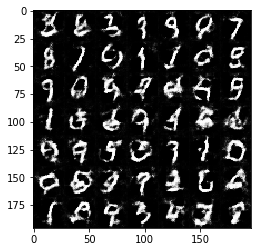

Epoch 2/2 Discriminator loss 0.9898 Generator loss 0.7002
Epoch 2/2 Discriminator loss 0.9869 Generator loss 1.3683
Epoch 2/2 Discriminator loss 1.0562 Generator loss 0.6742
Epoch 2/2 Discriminator loss 0.9535 Generator loss 0.8963
Epoch 2/2 Discriminator loss 1.2336 Generator loss 0.4882
Epoch 2/2 Discriminator loss 1.0364 Generator loss 1.4175
Epoch 2/2 Discriminator loss 0.9543 Generator loss 0.9048
Epoch 2/2 Discriminator loss 1.1462 Generator loss 0.6352
Epoch 2/2 Discriminator loss 1.0480 Generator loss 1.4945
Epoch 2/2 Discriminator loss 1.2082 Generator loss 0.4894


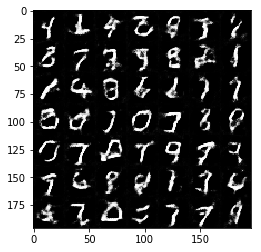

Epoch 2/2 Discriminator loss 1.1027 Generator loss 1.2888
Epoch 2/2 Discriminator loss 1.1255 Generator loss 0.5644
Epoch 2/2 Discriminator loss 1.1348 Generator loss 1.3528
Epoch 2/2 Discriminator loss 1.0009 Generator loss 0.6960
Epoch 2/2 Discriminator loss 1.2075 Generator loss 1.2391
Epoch 2/2 Discriminator loss 1.1796 Generator loss 0.5420
Epoch 2/2 Discriminator loss 1.0985 Generator loss 1.0679
Epoch 2/2 Discriminator loss 1.2429 Generator loss 0.5062
Epoch 2/2 Discriminator loss 1.0244 Generator loss 1.1630
Epoch 2/2 Discriminator loss 1.1632 Generator loss 0.5932


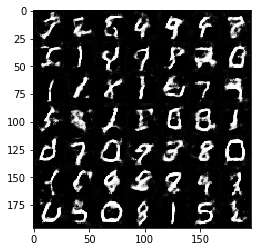

Epoch 2/2 Discriminator loss 0.9640 Generator loss 0.9046
Epoch 2/2 Discriminator loss 1.2310 Generator loss 1.2413
Epoch 2/2 Discriminator loss 1.4350 Generator loss 0.3499
Epoch 2/2 Discriminator loss 1.0823 Generator loss 1.3754
Epoch 2/2 Discriminator loss 1.0989 Generator loss 0.7414
Epoch 2/2 Discriminator loss 1.0349 Generator loss 0.9820
Epoch 2/2 Discriminator loss 0.9626 Generator loss 1.0086
Epoch 2/2 Discriminator loss 0.9428 Generator loss 0.7932
Epoch 2/2 Discriminator loss 1.0741 Generator loss 1.5878
Epoch 2/2 Discriminator loss 1.2784 Generator loss 0.4694


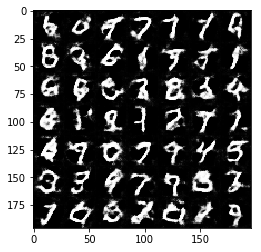

Epoch 2/2 Discriminator loss 1.2022 Generator loss 1.5695
Epoch 2/2 Discriminator loss 1.1080 Generator loss 0.6159
Epoch 2/2 Discriminator loss 1.2636 Generator loss 0.5075
Epoch 2/2 Discriminator loss 0.9725 Generator loss 1.1461
Epoch 2/2 Discriminator loss 1.3291 Generator loss 0.4419
Epoch 2/2 Discriminator loss 1.1215 Generator loss 1.3378
Epoch 2/2 Discriminator loss 1.0238 Generator loss 0.8629
Epoch 2/2 Discriminator loss 1.0095 Generator loss 1.0305
Epoch 2/2 Discriminator loss 0.9790 Generator loss 0.8987
Epoch 2/2 Discriminator loss 1.2461 Generator loss 0.5249


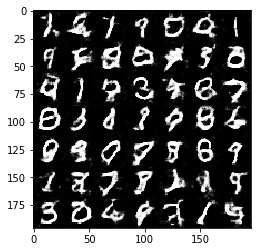

Epoch 2/2 Discriminator loss 1.1499 Generator loss 1.2574
Epoch 2/2 Discriminator loss 1.1110 Generator loss 0.7214
Epoch 2/2 Discriminator loss 0.8938 Generator loss 1.0260
Epoch 2/2 Discriminator loss 1.3087 Generator loss 0.4472
Epoch 2/2 Discriminator loss 0.9389 Generator loss 1.3180
Epoch 2/2 Discriminator loss 1.2840 Generator loss 0.4730
Epoch 2/2 Discriminator loss 1.1303 Generator loss 1.2613
Epoch 2/2 Discriminator loss 1.1895 Generator loss 0.5572
Epoch 2/2 Discriminator loss 1.1156 Generator loss 1.0040
Epoch 2/2 Discriminator loss 1.2601 Generator loss 0.4924


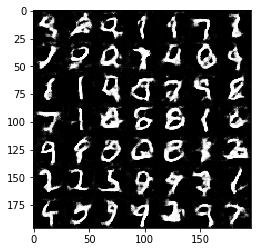

Epoch 2/2 Discriminator loss 1.0899 Generator loss 0.8543
Epoch 2/2 Discriminator loss 1.2305 Generator loss 0.4920
Epoch 2/2 Discriminator loss 1.1293 Generator loss 1.0394
Epoch 2/2 Discriminator loss 1.1265 Generator loss 0.6239
Epoch 2/2 Discriminator loss 0.9478 Generator loss 0.9520
Epoch 2/2 Discriminator loss 1.2091 Generator loss 0.4719
Epoch 2/2 Discriminator loss 1.0787 Generator loss 1.3013
Epoch 2/2 Discriminator loss 1.0988 Generator loss 0.6103
Epoch 2/2 Discriminator loss 1.2946 Generator loss 0.4191
Epoch 2/2 Discriminator loss 1.0683 Generator loss 0.9938


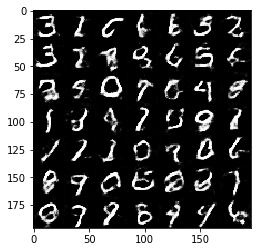

Epoch 2/2 Discriminator loss 1.1041 Generator loss 0.6345
Epoch 2/2 Discriminator loss 1.1030 Generator loss 1.3186
Epoch 2/2 Discriminator loss 1.3716 Generator loss 0.4086
Epoch 2/2 Discriminator loss 1.1074 Generator loss 1.1880
Epoch 2/2 Discriminator loss 1.0856 Generator loss 0.6355
Epoch 2/2 Discriminator loss 1.1206 Generator loss 1.2204
Epoch 2/2 Discriminator loss 1.1040 Generator loss 0.6050
Epoch 2/2 Discriminator loss 0.9465 Generator loss 0.9565
Epoch 2/2 Discriminator loss 0.8360 Generator loss 0.8166
Epoch 2/2 Discriminator loss 1.1606 Generator loss 1.8449


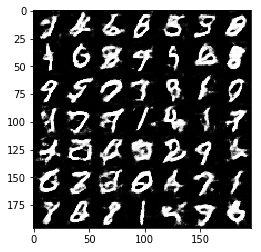

Epoch 2/2 Discriminator loss 1.3746 Generator loss 0.3979
Epoch 2/2 Discriminator loss 1.1914 Generator loss 0.7233
Epoch 2/2 Discriminator loss 1.1568 Generator loss 0.5347
Epoch 2/2 Discriminator loss 0.9698 Generator loss 1.2172
Epoch 2/2 Discriminator loss 1.0053 Generator loss 1.0179
Epoch 2/2 Discriminator loss 0.9311 Generator loss 0.8169
Epoch 2/2 Discriminator loss 0.9981 Generator loss 1.2318


In [84]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator loss 2.0883 Generator loss 0.3150
Epoch 1/1 Discriminator loss 1.5687 Generator loss 0.4486
Epoch 1/1 Discriminator loss 0.8437 Generator loss 1.3112
Epoch 1/1 Discriminator loss 1.0307 Generator loss 0.6662
Epoch 1/1 Discriminator loss 0.7300 Generator loss 1.3519
Epoch 1/1 Discriminator loss 0.7601 Generator loss 2.1390
Epoch 1/1 Discriminator loss 0.4696 Generator loss 1.5459
Epoch 1/1 Discriminator loss 0.6699 Generator loss 1.3277
Epoch 1/1 Discriminator loss 0.8523 Generator loss 0.8772
Epoch 1/1 Discriminator loss 0.7409 Generator loss 2.1790


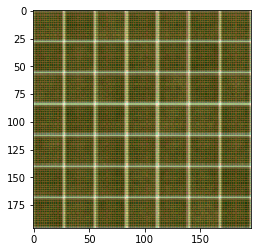

Epoch 1/1 Discriminator loss 0.6770 Generator loss 1.1028
Epoch 1/1 Discriminator loss 0.9719 Generator loss 0.6789
Epoch 1/1 Discriminator loss 0.9369 Generator loss 1.7747
Epoch 1/1 Discriminator loss 1.4355 Generator loss 3.2475
Epoch 1/1 Discriminator loss 1.2215 Generator loss 0.5099
Epoch 1/1 Discriminator loss 0.5635 Generator loss 2.7412
Epoch 1/1 Discriminator loss 1.0167 Generator loss 0.6751
Epoch 1/1 Discriminator loss 0.9197 Generator loss 2.2134
Epoch 1/1 Discriminator loss 0.6793 Generator loss 1.0424
Epoch 1/1 Discriminator loss 0.6542 Generator loss 1.1239


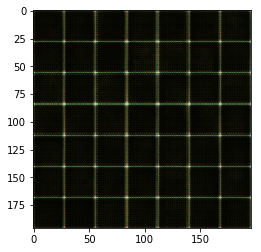

Epoch 1/1 Discriminator loss 1.4105 Generator loss 3.5956
Epoch 1/1 Discriminator loss 0.7234 Generator loss 1.0342
Epoch 1/1 Discriminator loss 0.8777 Generator loss 3.3561
Epoch 1/1 Discriminator loss 0.5811 Generator loss 1.3861
Epoch 1/1 Discriminator loss 1.0734 Generator loss 0.5393
Epoch 1/1 Discriminator loss 1.1421 Generator loss 1.6730
Epoch 1/1 Discriminator loss 0.7920 Generator loss 0.9871
Epoch 1/1 Discriminator loss 0.9010 Generator loss 0.6902
Epoch 1/1 Discriminator loss 1.2166 Generator loss 3.2171
Epoch 1/1 Discriminator loss 0.4319 Generator loss 1.6642


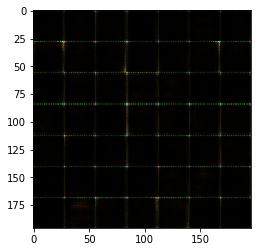

Epoch 1/1 Discriminator loss 1.6915 Generator loss 0.2635
Epoch 1/1 Discriminator loss 0.3538 Generator loss 2.7880
Epoch 1/1 Discriminator loss 0.7645 Generator loss 0.8718
Epoch 1/1 Discriminator loss 0.3557 Generator loss 2.6747
Epoch 1/1 Discriminator loss 0.4562 Generator loss 3.2161
Epoch 1/1 Discriminator loss 0.8321 Generator loss 0.7865
Epoch 1/1 Discriminator loss 1.4305 Generator loss 0.3599
Epoch 1/1 Discriminator loss 0.4024 Generator loss 2.2793
Epoch 1/1 Discriminator loss 1.2085 Generator loss 0.4594
Epoch 1/1 Discriminator loss 0.4670 Generator loss 3.8006


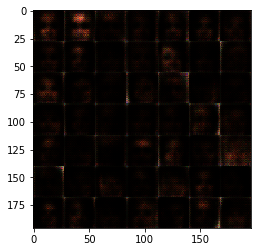

Epoch 1/1 Discriminator loss 0.8823 Generator loss 4.1637
Epoch 1/1 Discriminator loss 0.9378 Generator loss 0.7261
Epoch 1/1 Discriminator loss 1.1329 Generator loss 2.1551
Epoch 1/1 Discriminator loss 1.1333 Generator loss 0.5405
Epoch 1/1 Discriminator loss 0.7296 Generator loss 3.9154
Epoch 1/1 Discriminator loss 0.7964 Generator loss 1.0443
Epoch 1/1 Discriminator loss 0.6932 Generator loss 3.3055
Epoch 1/1 Discriminator loss 0.7620 Generator loss 4.5304
Epoch 1/1 Discriminator loss 0.6064 Generator loss 1.2323
Epoch 1/1 Discriminator loss 1.7210 Generator loss 0.2516


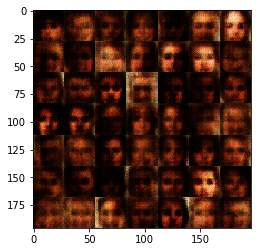

Epoch 1/1 Discriminator loss 0.5513 Generator loss 3.3126
Epoch 1/1 Discriminator loss 1.9355 Generator loss 0.2122
Epoch 1/1 Discriminator loss 0.8148 Generator loss 1.7514
Epoch 1/1 Discriminator loss 0.5300 Generator loss 2.2932
Epoch 1/1 Discriminator loss 1.8096 Generator loss 0.2414
Epoch 1/1 Discriminator loss 0.8153 Generator loss 2.2989
Epoch 1/1 Discriminator loss 1.2492 Generator loss 2.6501
Epoch 1/1 Discriminator loss 0.3288 Generator loss 2.0963
Epoch 1/1 Discriminator loss 1.7077 Generator loss 0.3006
Epoch 1/1 Discriminator loss 1.2456 Generator loss 0.5097


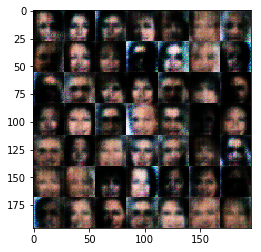

Epoch 1/1 Discriminator loss 1.1136 Generator loss 2.5851
Epoch 1/1 Discriminator loss 0.5891 Generator loss 1.2688
Epoch 1/1 Discriminator loss 1.0642 Generator loss 2.1699
Epoch 1/1 Discriminator loss 1.4496 Generator loss 0.4771
Epoch 1/1 Discriminator loss 1.0584 Generator loss 1.8483
Epoch 1/1 Discriminator loss 1.9909 Generator loss 0.2121
Epoch 1/1 Discriminator loss 1.3963 Generator loss 0.9330
Epoch 1/1 Discriminator loss 0.8248 Generator loss 0.9433
Epoch 1/1 Discriminator loss 1.3305 Generator loss 1.2680
Epoch 1/1 Discriminator loss 0.9234 Generator loss 1.3032


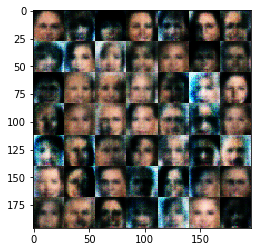

Epoch 1/1 Discriminator loss 1.3955 Generator loss 0.3974
Epoch 1/1 Discriminator loss 0.7305 Generator loss 1.5141
Epoch 1/1 Discriminator loss 1.5618 Generator loss 0.3319
Epoch 1/1 Discriminator loss 0.8680 Generator loss 1.5032
Epoch 1/1 Discriminator loss 0.8308 Generator loss 0.7646
Epoch 1/1 Discriminator loss 1.0062 Generator loss 3.4072
Epoch 1/1 Discriminator loss 1.6426 Generator loss 0.3326
Epoch 1/1 Discriminator loss 0.9353 Generator loss 1.9881
Epoch 1/1 Discriminator loss 1.6848 Generator loss 0.2775
Epoch 1/1 Discriminator loss 1.4848 Generator loss 1.2761


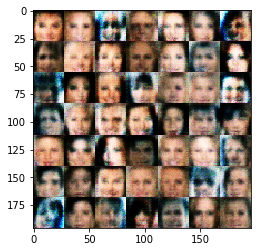

Epoch 1/1 Discriminator loss 0.7590 Generator loss 0.8926
Epoch 1/1 Discriminator loss 1.2317 Generator loss 2.5112
Epoch 1/1 Discriminator loss 1.4480 Generator loss 0.5975
Epoch 1/1 Discriminator loss 0.8082 Generator loss 1.3386
Epoch 1/1 Discriminator loss 0.9721 Generator loss 0.7108
Epoch 1/1 Discriminator loss 1.4275 Generator loss 1.7245
Epoch 1/1 Discriminator loss 1.4262 Generator loss 0.3801
Epoch 1/1 Discriminator loss 0.6666 Generator loss 3.6191
Epoch 1/1 Discriminator loss 1.6081 Generator loss 0.3527
Epoch 1/1 Discriminator loss 1.2453 Generator loss 0.9122


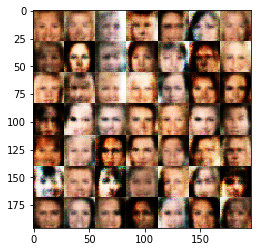

Epoch 1/1 Discriminator loss 0.8748 Generator loss 3.1056
Epoch 1/1 Discriminator loss 1.4864 Generator loss 0.4163
Epoch 1/1 Discriminator loss 1.1369 Generator loss 4.3150
Epoch 1/1 Discriminator loss 1.2558 Generator loss 0.5372
Epoch 1/1 Discriminator loss 1.4281 Generator loss 1.0118
Epoch 1/1 Discriminator loss 1.5365 Generator loss 0.3927
Epoch 1/1 Discriminator loss 0.8724 Generator loss 2.4393
Epoch 1/1 Discriminator loss 1.0766 Generator loss 0.8093
Epoch 1/1 Discriminator loss 1.1250 Generator loss 2.1783
Epoch 1/1 Discriminator loss 1.2599 Generator loss 0.6151


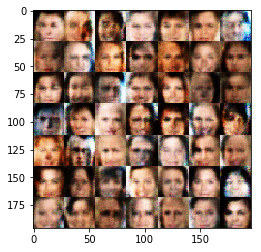

Epoch 1/1 Discriminator loss 0.8747 Generator loss 2.2138
Epoch 1/1 Discriminator loss 1.5678 Generator loss 0.3722
Epoch 1/1 Discriminator loss 0.9440 Generator loss 1.7399
Epoch 1/1 Discriminator loss 1.5077 Generator loss 0.3571
Epoch 1/1 Discriminator loss 0.9093 Generator loss 1.9869
Epoch 1/1 Discriminator loss 1.8222 Generator loss 0.2222
Epoch 1/1 Discriminator loss 0.9422 Generator loss 2.0108
Epoch 1/1 Discriminator loss 1.6137 Generator loss 0.3232
Epoch 1/1 Discriminator loss 0.9382 Generator loss 1.2174
Epoch 1/1 Discriminator loss 1.5910 Generator loss 0.3038


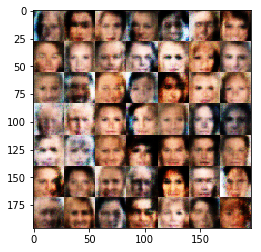

Epoch 1/1 Discriminator loss 1.0039 Generator loss 1.3758
Epoch 1/1 Discriminator loss 1.2497 Generator loss 0.4627
Epoch 1/1 Discriminator loss 1.0209 Generator loss 1.3019
Epoch 1/1 Discriminator loss 1.3798 Generator loss 0.4091
Epoch 1/1 Discriminator loss 1.0412 Generator loss 1.8616
Epoch 1/1 Discriminator loss 1.5017 Generator loss 0.3407
Epoch 1/1 Discriminator loss 1.3327 Generator loss 1.2968
Epoch 1/1 Discriminator loss 1.5001 Generator loss 0.3419
Epoch 1/1 Discriminator loss 1.0095 Generator loss 1.3086
Epoch 1/1 Discriminator loss 1.2091 Generator loss 0.4737


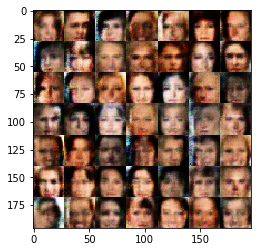

Epoch 1/1 Discriminator loss 1.1188 Generator loss 1.5254
Epoch 1/1 Discriminator loss 1.2117 Generator loss 0.5037
Epoch 1/1 Discriminator loss 1.1301 Generator loss 1.1474
Epoch 1/1 Discriminator loss 0.8583 Generator loss 0.9084
Epoch 1/1 Discriminator loss 0.9801 Generator loss 2.1217
Epoch 1/1 Discriminator loss 1.1931 Generator loss 0.5524
Epoch 1/1 Discriminator loss 0.9708 Generator loss 2.2354
Epoch 1/1 Discriminator loss 1.5970 Generator loss 0.3190
Epoch 1/1 Discriminator loss 1.1182 Generator loss 2.1861
Epoch 1/1 Discriminator loss 1.2869 Generator loss 0.4269


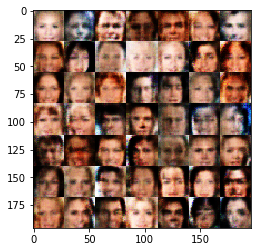

Epoch 1/1 Discriminator loss 1.0150 Generator loss 1.4900
Epoch 1/1 Discriminator loss 0.9616 Generator loss 0.7797
Epoch 1/1 Discriminator loss 0.8536 Generator loss 1.9374
Epoch 1/1 Discriminator loss 0.8933 Generator loss 1.0225
Epoch 1/1 Discriminator loss 0.6976 Generator loss 2.1427
Epoch 1/1 Discriminator loss 1.3144 Generator loss 0.4963
Epoch 1/1 Discriminator loss 0.7534 Generator loss 2.1607
Epoch 1/1 Discriminator loss 1.1175 Generator loss 0.6309
Epoch 1/1 Discriminator loss 1.0110 Generator loss 2.1012
Epoch 1/1 Discriminator loss 1.2652 Generator loss 0.5829


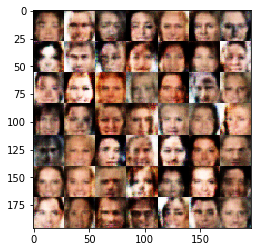

Epoch 1/1 Discriminator loss 0.7038 Generator loss 1.9603
Epoch 1/1 Discriminator loss 1.1036 Generator loss 0.5873
Epoch 1/1 Discriminator loss 1.0198 Generator loss 2.8288
Epoch 1/1 Discriminator loss 1.4495 Generator loss 0.4024
Epoch 1/1 Discriminator loss 0.8187 Generator loss 2.6515
Epoch 1/1 Discriminator loss 1.1947 Generator loss 0.5617
Epoch 1/1 Discriminator loss 1.0666 Generator loss 1.9237
Epoch 1/1 Discriminator loss 1.4413 Generator loss 0.3917
Epoch 1/1 Discriminator loss 0.8055 Generator loss 2.7737
Epoch 1/1 Discriminator loss 1.2647 Generator loss 0.5668


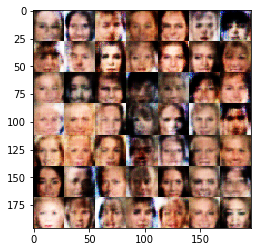

Epoch 1/1 Discriminator loss 0.7719 Generator loss 1.4312
Epoch 1/1 Discriminator loss 0.7047 Generator loss 2.8259
Epoch 1/1 Discriminator loss 1.1526 Generator loss 0.8460
Epoch 1/1 Discriminator loss 1.1452 Generator loss 0.5081
Epoch 1/1 Discriminator loss 0.7181 Generator loss 1.7543
Epoch 1/1 Discriminator loss 0.9280 Generator loss 3.4312
Epoch 1/1 Discriminator loss 1.3344 Generator loss 0.5311
Epoch 1/1 Discriminator loss 1.0826 Generator loss 0.5565
Epoch 1/1 Discriminator loss 1.7219 Generator loss 1.4741
Epoch 1/1 Discriminator loss 0.8983 Generator loss 0.8127


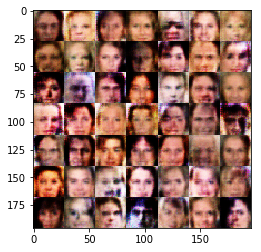

Epoch 1/1 Discriminator loss 1.2288 Generator loss 1.1069
Epoch 1/1 Discriminator loss 1.5052 Generator loss 0.3365
Epoch 1/1 Discriminator loss 1.2338 Generator loss 1.1192
Epoch 1/1 Discriminator loss 1.2677 Generator loss 0.4950
Epoch 1/1 Discriminator loss 1.1016 Generator loss 1.8849
Epoch 1/1 Discriminator loss 1.1748 Generator loss 0.5054
Epoch 1/1 Discriminator loss 1.1848 Generator loss 1.3677
Epoch 1/1 Discriminator loss 1.2818 Generator loss 0.4706
Epoch 1/1 Discriminator loss 1.0095 Generator loss 2.2873
Epoch 1/1 Discriminator loss 1.0007 Generator loss 0.7351


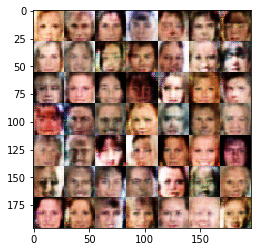

Epoch 1/1 Discriminator loss 0.5555 Generator loss 2.7940
Epoch 1/1 Discriminator loss 0.9031 Generator loss 0.8949
Epoch 1/1 Discriminator loss 0.9653 Generator loss 1.6965
Epoch 1/1 Discriminator loss 1.2425 Generator loss 0.5196
Epoch 1/1 Discriminator loss 1.7256 Generator loss 1.4660
Epoch 1/1 Discriminator loss 0.8851 Generator loss 0.8325
Epoch 1/1 Discriminator loss 0.8063 Generator loss 1.8625
Epoch 1/1 Discriminator loss 1.1310 Generator loss 0.5373
Epoch 1/1 Discriminator loss 1.0059 Generator loss 2.0168
Epoch 1/1 Discriminator loss 1.4857 Generator loss 0.3395


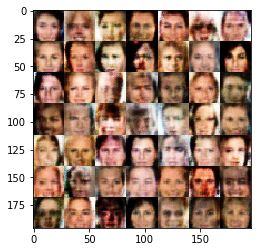

Epoch 1/1 Discriminator loss 1.0467 Generator loss 1.4881
Epoch 1/1 Discriminator loss 0.6053 Generator loss 2.3081
Epoch 1/1 Discriminator loss 0.9766 Generator loss 0.9275
Epoch 1/1 Discriminator loss 0.7784 Generator loss 2.3368
Epoch 1/1 Discriminator loss 2.1198 Generator loss 0.1598
Epoch 1/1 Discriminator loss 0.8277 Generator loss 2.3505
Epoch 1/1 Discriminator loss 1.2663 Generator loss 0.4762
Epoch 1/1 Discriminator loss 0.6530 Generator loss 1.9256
Epoch 1/1 Discriminator loss 1.1202 Generator loss 0.6128
Epoch 1/1 Discriminator loss 1.2615 Generator loss 2.2736


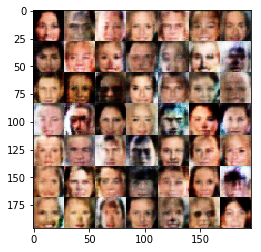

Epoch 1/1 Discriminator loss 1.0249 Generator loss 0.8238
Epoch 1/1 Discriminator loss 0.8101 Generator loss 1.5403
Epoch 1/1 Discriminator loss 1.1610 Generator loss 0.5558
Epoch 1/1 Discriminator loss 1.2577 Generator loss 1.6830
Epoch 1/1 Discriminator loss 0.8671 Generator loss 0.9306
Epoch 1/1 Discriminator loss 1.0068 Generator loss 2.3375
Epoch 1/1 Discriminator loss 1.2994 Generator loss 0.4680
Epoch 1/1 Discriminator loss 0.7876 Generator loss 1.0041
Epoch 1/1 Discriminator loss 1.3954 Generator loss 0.3979
Epoch 1/1 Discriminator loss 0.8709 Generator loss 2.1230


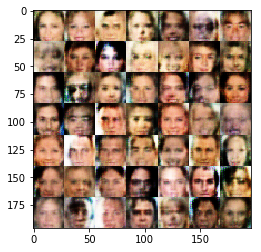

Epoch 1/1 Discriminator loss 0.8621 Generator loss 0.7748
Epoch 1/1 Discriminator loss 1.7472 Generator loss 1.7455
Epoch 1/1 Discriminator loss 1.2853 Generator loss 0.4157
Epoch 1/1 Discriminator loss 0.7301 Generator loss 1.8274
Epoch 1/1 Discriminator loss 1.3864 Generator loss 0.4396
Epoch 1/1 Discriminator loss 1.1808 Generator loss 0.5528
Epoch 1/1 Discriminator loss 0.9292 Generator loss 3.5761
Epoch 1/1 Discriminator loss 0.9581 Generator loss 0.8918
Epoch 1/1 Discriminator loss 1.4912 Generator loss 0.3592
Epoch 1/1 Discriminator loss 0.7241 Generator loss 2.1563


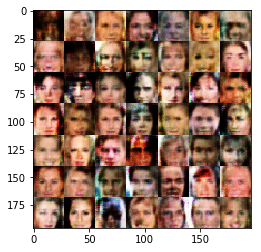

Epoch 1/1 Discriminator loss 1.1395 Generator loss 0.6899
Epoch 1/1 Discriminator loss 1.0351 Generator loss 0.5705
Epoch 1/1 Discriminator loss 1.7856 Generator loss 1.1873
Epoch 1/1 Discriminator loss 0.5221 Generator loss 2.0062
Epoch 1/1 Discriminator loss 1.0391 Generator loss 0.6721
Epoch 1/1 Discriminator loss 1.1063 Generator loss 1.2068
Epoch 1/1 Discriminator loss 1.1289 Generator loss 0.5694
Epoch 1/1 Discriminator loss 0.6552 Generator loss 1.7252
Epoch 1/1 Discriminator loss 0.7967 Generator loss 1.0247
Epoch 1/1 Discriminator loss 0.7009 Generator loss 1.3145


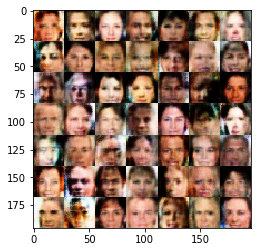

Epoch 1/1 Discriminator loss 0.7848 Generator loss 2.7352
Epoch 1/1 Discriminator loss 0.9995 Generator loss 0.7325
Epoch 1/1 Discriminator loss 0.4814 Generator loss 2.5321
Epoch 1/1 Discriminator loss 1.2509 Generator loss 0.5183
Epoch 1/1 Discriminator loss 0.7941 Generator loss 0.8909
Epoch 1/1 Discriminator loss 0.6984 Generator loss 2.6677
Epoch 1/1 Discriminator loss 2.1763 Generator loss 0.1456
Epoch 1/1 Discriminator loss 0.9580 Generator loss 1.7231
Epoch 1/1 Discriminator loss 0.9328 Generator loss 0.7250
Epoch 1/1 Discriminator loss 0.8137 Generator loss 1.2894


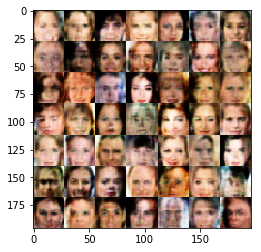

Epoch 1/1 Discriminator loss 1.1676 Generator loss 0.4988
Epoch 1/1 Discriminator loss 1.4940 Generator loss 1.8206
Epoch 1/1 Discriminator loss 1.3230 Generator loss 0.5404
Epoch 1/1 Discriminator loss 0.5899 Generator loss 2.1890
Epoch 1/1 Discriminator loss 1.6505 Generator loss 0.2657
Epoch 1/1 Discriminator loss 0.7046 Generator loss 2.4358
Epoch 1/1 Discriminator loss 1.3695 Generator loss 0.3993
Epoch 1/1 Discriminator loss 1.0308 Generator loss 1.5681
Epoch 1/1 Discriminator loss 0.6285 Generator loss 1.3244
Epoch 1/1 Discriminator loss 0.6347 Generator loss 2.0216


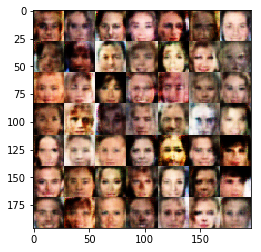

Epoch 1/1 Discriminator loss 0.5460 Generator loss 2.1651
Epoch 1/1 Discriminator loss 1.9715 Generator loss 0.1888
Epoch 1/1 Discriminator loss 1.0067 Generator loss 0.6144
Epoch 1/1 Discriminator loss 0.9594 Generator loss 1.2331
Epoch 1/1 Discriminator loss 0.5942 Generator loss 1.5407
Epoch 1/1 Discriminator loss 0.6085 Generator loss 2.2819
Epoch 1/1 Discriminator loss 2.0655 Generator loss 0.1664
Epoch 1/1 Discriminator loss 1.5018 Generator loss 0.8934
Epoch 1/1 Discriminator loss 0.5428 Generator loss 1.7685
Epoch 1/1 Discriminator loss 1.0430 Generator loss 0.6968


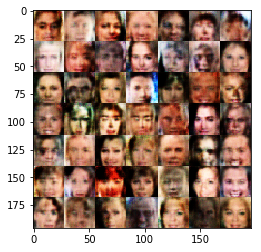

Epoch 1/1 Discriminator loss 0.6781 Generator loss 1.0872
Epoch 1/1 Discriminator loss 1.0502 Generator loss 0.9969
Epoch 1/1 Discriminator loss 0.5504 Generator loss 2.1158
Epoch 1/1 Discriminator loss 0.8167 Generator loss 0.9172
Epoch 1/1 Discriminator loss 0.8622 Generator loss 2.3797
Epoch 1/1 Discriminator loss 1.7372 Generator loss 0.2393
Epoch 1/1 Discriminator loss 0.5583 Generator loss 1.6397
Epoch 1/1 Discriminator loss 0.5579 Generator loss 1.5215
Epoch 1/1 Discriminator loss 1.1000 Generator loss 0.5425
Epoch 1/1 Discriminator loss 1.1238 Generator loss 3.0659


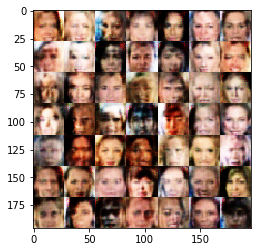

Epoch 1/1 Discriminator loss 0.9156 Generator loss 2.0552
Epoch 1/1 Discriminator loss 1.1429 Generator loss 2.5106
Epoch 1/1 Discriminator loss 0.9364 Generator loss 0.6919
Epoch 1/1 Discriminator loss 1.5297 Generator loss 1.3626
Epoch 1/1 Discriminator loss 0.5602 Generator loss 2.2847
Epoch 1/1 Discriminator loss 0.6050 Generator loss 1.4536
Epoch 1/1 Discriminator loss 1.0456 Generator loss 0.5869
Epoch 1/1 Discriminator loss 0.6143 Generator loss 2.5688
Epoch 1/1 Discriminator loss 1.3938 Generator loss 0.3607
Epoch 1/1 Discriminator loss 0.5109 Generator loss 1.9709


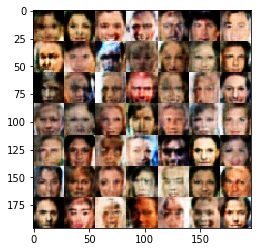

Epoch 1/1 Discriminator loss 0.6852 Generator loss 1.3945
Epoch 1/1 Discriminator loss 1.1872 Generator loss 0.6976
Epoch 1/1 Discriminator loss 1.2932 Generator loss 0.3880
Epoch 1/1 Discriminator loss 0.6630 Generator loss 1.9236
Epoch 1/1 Discriminator loss 1.8596 Generator loss 0.1990
Epoch 1/1 Discriminator loss 0.7789 Generator loss 0.9037
Epoch 1/1 Discriminator loss 0.6731 Generator loss 2.0676
Epoch 1/1 Discriminator loss 0.8009 Generator loss 0.8393
Epoch 1/1 Discriminator loss 1.3649 Generator loss 4.1204
Epoch 1/1 Discriminator loss 1.1687 Generator loss 0.4843


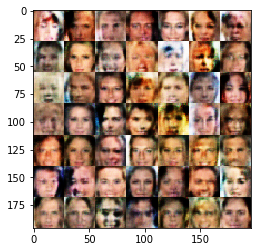

Epoch 1/1 Discriminator loss 0.6366 Generator loss 2.5801
Epoch 1/1 Discriminator loss 0.8097 Generator loss 2.7011
Epoch 1/1 Discriminator loss 0.7234 Generator loss 0.8480
Epoch 1/1 Discriminator loss 0.6669 Generator loss 1.1980
Epoch 1/1 Discriminator loss 0.5766 Generator loss 2.8448
Epoch 1/1 Discriminator loss 1.9046 Generator loss 0.2294
Epoch 1/1 Discriminator loss 1.8885 Generator loss 1.3255
Epoch 1/1 Discriminator loss 1.2068 Generator loss 1.7844
Epoch 1/1 Discriminator loss 1.6308 Generator loss 0.3186
Epoch 1/1 Discriminator loss 0.8283 Generator loss 0.8697


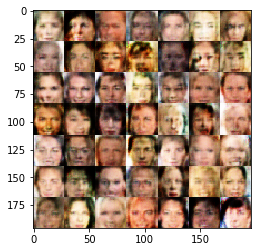

Epoch 1/1 Discriminator loss 1.4333 Generator loss 0.5407
Epoch 1/1 Discriminator loss 1.2712 Generator loss 1.5244
Epoch 1/1 Discriminator loss 0.6627 Generator loss 1.0580
Epoch 1/1 Discriminator loss 0.7863 Generator loss 1.4864
Epoch 1/1 Discriminator loss 0.6515 Generator loss 1.2515
Epoch 1/1 Discriminator loss 0.6107 Generator loss 1.1830
Epoch 1/1 Discriminator loss 0.5658 Generator loss 2.8269
Epoch 1/1 Discriminator loss 0.9486 Generator loss 1.0435
Epoch 1/1 Discriminator loss 0.3603 Generator loss 1.8736
Epoch 1/1 Discriminator loss 0.6430 Generator loss 1.0107


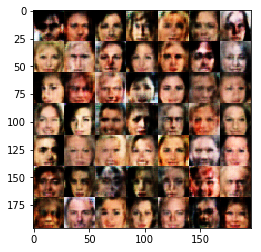

Epoch 1/1 Discriminator loss 0.6363 Generator loss 1.8005
Epoch 1/1 Discriminator loss 1.0305 Generator loss 2.3009
Epoch 1/1 Discriminator loss 1.1209 Generator loss 0.5199
Epoch 1/1 Discriminator loss 1.3166 Generator loss 0.4746
Epoch 1/1 Discriminator loss 1.2561 Generator loss 1.6821
Epoch 1/1 Discriminator loss 0.8821 Generator loss 1.9237
Epoch 1/1 Discriminator loss 1.0374 Generator loss 0.6227
Epoch 1/1 Discriminator loss 0.6746 Generator loss 2.3220
Epoch 1/1 Discriminator loss 0.7486 Generator loss 1.5378
Epoch 1/1 Discriminator loss 1.1619 Generator loss 0.5185


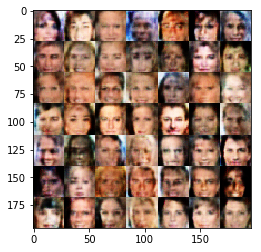

Epoch 1/1 Discriminator loss 0.7304 Generator loss 1.4608
Epoch 1/1 Discriminator loss 0.6080 Generator loss 1.4039
Epoch 1/1 Discriminator loss 1.1926 Generator loss 0.4644
Epoch 1/1 Discriminator loss 0.9379 Generator loss 1.3200
Epoch 1/1 Discriminator loss 0.6473 Generator loss 1.1529
Epoch 1/1 Discriminator loss 1.0962 Generator loss 0.5794


In [85]:
batch_size = 128
z_dim = 28
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.